# 从头开始实现llama3
在这个文件中，我逐个张量和矩阵地从头实现了llama3。
<br>
此外，我将直接从meta提供给llama3的模型文件中加载张量，你需要在运行此文件之前下载权重。
这是下载权重的官方链接: [点击这里下载权重](https://llama.meta.com/llama-downloads/)

<div>
    <img src="images/archi.png"/>
</div>

## 分词器
我不打算实现一个BPE分词器（但是Andrej Karpathy有一个非常干净的实现）。
<br>
他的实现链接: [点击这里查看他的实现](https://github.com/karpathy/minbpe)

<div>
    <img src="images/karpathyminbpe.png" width="600"/>
</div>

In [1]:
%env HF_ENDPOINT = "https://hf-mirror.com"

env: HF_ENDPOINT="https://hf-mirror.com"


In [3]:
%pip install blobfile -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "./tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

## 读取模型文件
通常，读取模型文件取决于模型类的编写方式以及其中的变量名。
<br>
但由于我们是从头开始实现llama3，我们将逐个张量地读取文件。

<div>
    <img src="images/model.png" width="600"/>
</div>

可以在这里下载模型：https://gitee.com/hf-models/Meta-Llama-3-8B-Instruct/blob/main/original/consolidated.00.pth

In [8]:
!wget 'https://lfs.gitee.com/api/lfs/storage/projects/34266234/be52262c9289304f3e8240e0749bf257bc04264405a86cd4de38efb9068724ee?Expires=1716626632&Signature=xgDOu9JHNM6ECazR3nA4NQHwXs%2BiG%2BCtnzza6ekSuqs%3D&FileName=consolidated.00.pth'

--2024-05-25 16:24:15--  https://lfs.gitee.com/api/lfs/storage/projects/34266234/be52262c9289304f3e8240e0749bf257bc04264405a86cd4de38efb9068724ee?Expires=1716626632&Signature=xgDOu9JHNM6ECazR3nA4NQHwXs%2BiG%2BCtnzza6ekSuqs%3D&FileName=consolidated.00.pth
Resolving lfs.gitee.com (lfs.gitee.com)... 180.76.198.180
Connecting to lfs.gitee.com (lfs.gitee.com)|180.76.198.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16060617592 (15G) [application/octet-stream]
Saving to: ‘be52262c9289304f3e8240e0749bf257bc04264405a86cd4de38efb9068724ee?Expires=1716626632&Signature=xgDOu9JHNM6ECazR3nA4NQHwXs+iG+Ctnzza6ekSuqs=&FileName=consolidated.00.pth’

 0% [                                       ] 105,193,134  453KB/s  eta 11h 21m^C


我的机器12s可以载入，接下来仅用cpu进行推理，我这边内存30G足够了，然后cpu推理一个词大约30s，稍微慢了一些，不过我们主要理解原理

In [3]:
model = torch.load("/data1/ckw/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [4]:
with open("./params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

## 我们使用这个配置来推断模型的细节，比如：
1. 模型有32个Transformer层
2. 每个多头注意力块有32个头
3. 词汇表大小，等等

In [5]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## 将文本转换为标记
这里我们使用tiktoken（我认为是OpenAI的一个库）作为分词器

<div>
    <img src="images/tokens.png" width="600"/>
</div>

In [6]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## 将标记转换为它们的嵌入向量
这是代码库中我唯一使用内置神经网络模块的部分。
<br>
无论如何，我们的[17x1]标记现在是[17x4096]，即长度为4096的17个嵌入向量（每个标记一个）。
<br>
<br>
注意: 跟踪形状，这样可以更容易理解所有内容

<div>
    <img src="images/embeddings.png" width="600"/>
</div>

In [7]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

## 然后我们使用RMS归一化来标准化嵌入向量
请注意，在此步骤之后，形状不会改变，只是值被标准化了。
<br>
需要记住的一些事情，我们需要一个norm_eps（来自配置），因为我们不希望意外地将RMS设置为0并除以0。
<br>
以下是公式：
<div>
    <img src="images/rms.png" width="600"/>
</div>

In [8]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

# 构建Transformer的第一层

### 标准化
你会看到我从模型字典中访问layer.0（这是第一层）。
<br>
无论如何，所以在我们标准化后，形状仍然是[17x4096]，与嵌入向量相同，但是标准化了

<div>
    <img src="images/norm.png" width="600"/>
</div>

In [9]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

### 从头实现的注意力机制
让我们加载Transformer第一层的注意力头

<div>
    <img src="images/qkv.png" width="600"/>
</div>

<br>

&gt; 当我们从模型中加载查询（query）、键（key）、值（value）和输出（output）向量时，我们注意到它们的形状为[4096x4096]、[1024x4096]、[1024x4096]、[4096x4096]
<br>
&gt; 乍一看这有点奇怪，因为理想情况下我们希望每个注意力头的q、k、v和o都是分开的
<br>
&gt; 代码的作者将它们捆绑在一起，因为这样做容易并行化注意力头的乘法。
<br>
&gt; 我要将所有东西解开...

In [10]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### 解开查询
在下一节中，我们将从多个注意力头中解开查询，结果形状为[32x128x4096]
<br><br>
这里，32是llama3中的注意力头数量，128是查询向量的大小，4096是标记嵌入的大小

In [12]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

### 我要实现第一层的第一个注意力头
在这里，我首先访问第一层的第一个注意力头的查询权重矩阵，该查询权重矩阵的大小为[128x4096]

In [13]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

### 现在我们将查询权重与标记嵌入相乘，以获得每个标记的查询
在这里，你可以看到结果的形状为[17x128]，这是因为我们有17个标记，对于每个标记，都有一个长度为128的查询。

<div>
    <img src="images/q_per_token.png" width="600"/>
</div>

In [14]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

## 位置编码
现在我们处于这样一个阶段：我们在我们的提示中为每个标记都有一个查询向量，但是如果你想一想--每个单独的查询向量并不知道在提示中的位置。
<br><br>
查询："生命、宇宙和一切的终极问题的答案是"
<br><br>
在我们的提示中，我们使用了"the"三次，我们需要所有3个"the"标记的查询向量都根据它们在查询中的位置有不同的查询向量（每个大小为[1x128]）。我们使用RoPE（旋转位置编码）来执行这些旋转。
<br><br>
### RoPE
观看这个视频（这是我看的）以理解数学原理。
[点击这里观看视频](https://www.youtube.com/watch?v=o29P0Kpobz0&t=530s)

<div>
    <img src="images/rope.png" width="600"/>
</div>

In [15]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

在上述步骤中，我们将查询向量分成一对对，对每对应用旋转角度偏移！
<br><br>
现在我们有一个大小为[17x64x2]的向量，这是128长度的查询分成64对，对于提示中的每个标记！每个这样的64对将通过m*(theta)进行旋转，其中m是我们正在旋转查询的标记的位置！

<div>
    <img src="images/qsplit.png" width="600"/>
</div>

## 使用复数的点积来旋转向量
<div>
    <img src="images/freq_cis.png" width="600"/>
</div>

In [16]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [17]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [21]:
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

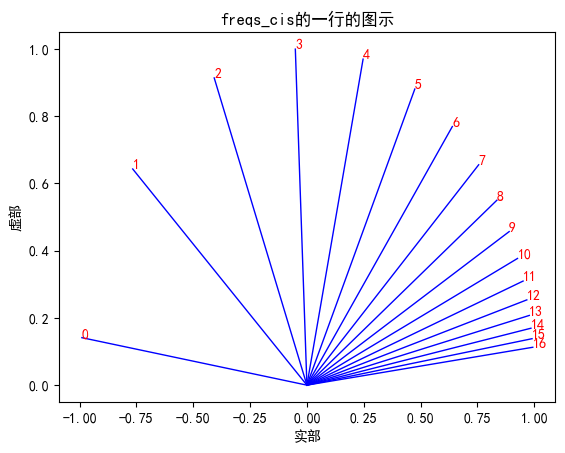

In [22]:
plt.rcParams["font.sans-serif"]=['simhei']
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# 查看freqs_cis的第三行
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('实部')
plt.ylabel('虚部')
plt.title('freqs_cis的一行的图示')
plt.show()


### 现在我们为每个标记的查询元素有了一个复数（角度变化向量）
我们可以将我们的查询（我们分成对的那些）转换为复数，然后进行点积来根据位置旋转查询
<br>
说实话，这样想真的很美 :)

In [23]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [24]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

### 在获得旋转向量后
我们可以通过将复数视为实数来重新获取我们的查询对

In [25]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

旋转后的查询对现已合并，我们现在有一个新的查询向量（旋转后的查询向量），其形状为\[17x128\]，其中17表示标记数量，128表示查询向量的维度。

In [26]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

# 键（几乎与查询相同）
<div>
    <img src="images/keys.png" width="600px"/>
</div>
我太懒了，所以我不打算为键做数学推导，你需要记住的几点是：
<br>
&gt; 键生成的键向量也是128维的
<br>
&gt; 键的权重数量只有查询的四分之一，这是因为键的权重在4个头中共享，以减少计算量
<br>
&gt; 键也会旋转以添加位置信息，与查询一样，因为同样的原因

In [27]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [28]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [29]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [30]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [31]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [32]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [33]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

## 在这个阶段，我们现在对于每个标记都有了旋转后的查询和键的值。
<div>
    <img src="images/keys0.png" width="600px"/>
</div>
每个查询和键现在的形状都是[17x128]。

## 下一步我们将对查询和键矩阵进行相乘
这样做将为我们提供一个将每个标记相互映射的分数
<br>
这个分数描述了每个标记的查询与每个标记的键之间的关系。
这就是自注意力机制 :)
<br>
注意力分数矩阵的形状（qk_per_token）是[17x17]，其中17是提示中的标记数量

<div>
    <img src="images/qkmatmul.png" width="600px"/>
</div>

In [34]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

# 现在我们需要对查询键分数进行掩码处理
在llama3的训练过程中，未来标记的查询键分数是被掩码的。
<br>
为什么？因为在训练过程中，我们只学习使用过去的标记来预测标记。
<br>
因此，在推理过程中，我们将未来的标记分数设置为零。

<div>
    <img src="images/mask.png" width="600px"/>
</div>

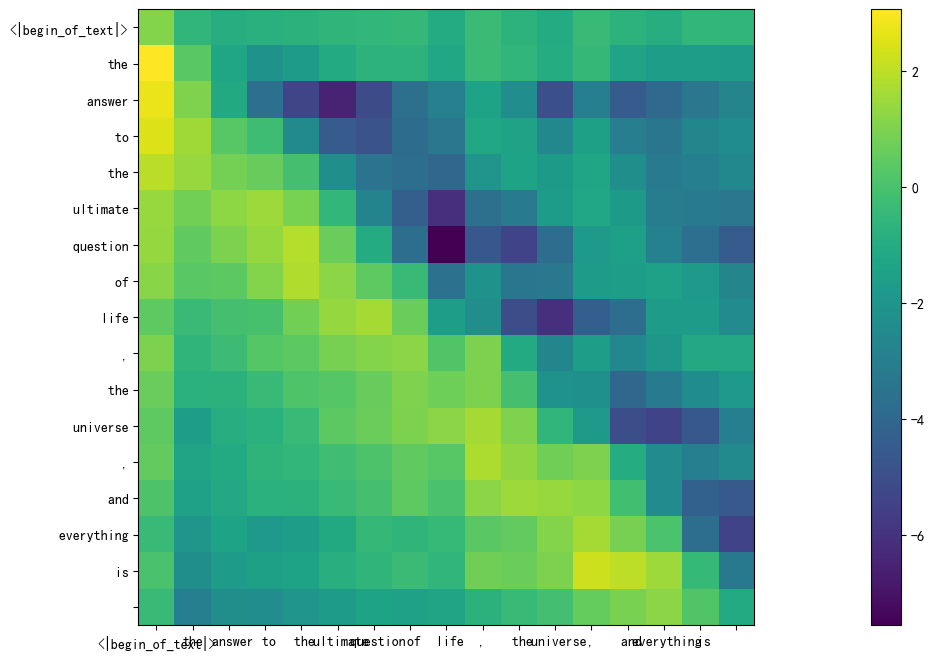

In [38]:
def display_qk_heatmap(qk_per_token):
    fig, ax = plt.subplots(figsize=(30, 8))  # 设置图像大小为12x8英寸
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token)


In [39]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

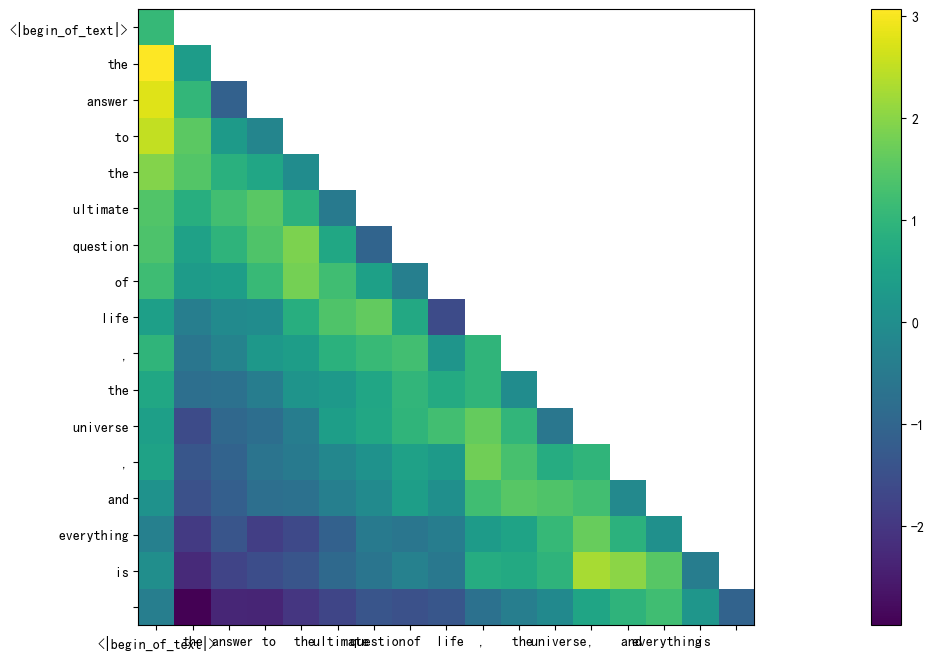

In [40]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

<div>
    <img src="images/softmax.png" width="600px"/>
</div>

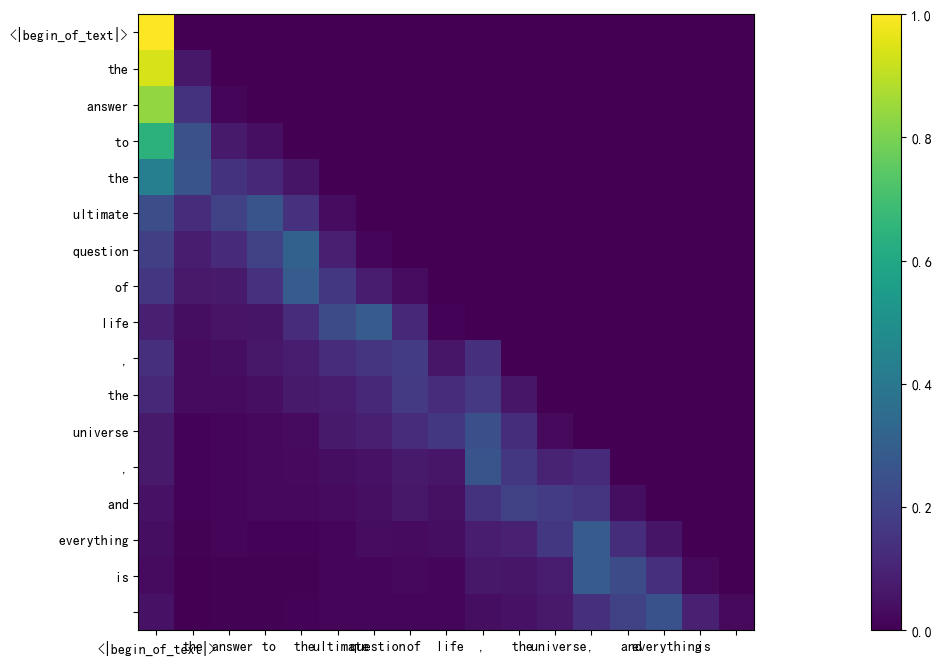

In [41]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## 值（注意力机制的最后一步）

<div>
    <img src="images/value.png" width="600px"/>
</div>
这些分数（0-1）用于确定每个标记使用多少值矩阵
<br>
&gt; 就像键一样，值的权重也在每4个注意力头中共享（以节省计算）
<br>
&gt; 因此，下面值权重矩阵的形状是[8x128x4096]

In [42]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

第一层，第一个注意力头的值权重矩阵如下所示：

In [43]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

## 值向量
<div>
    <img src="images/v0.png" width="600px"/>
</div>
我们现在使用值权重来获取每个标记的注意力值，其大小为[17x128]，其中17是提示中的标记数量，128是每个标记的值向量维度。

In [45]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

## 注意力机制
<div>
    <img src="images/attention.png" width="600px"/>
</div>
与每个标记的值相乘后得到的注意力向量的形状为[17x128]。

In [46]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

# 多头注意力机制
<div>
    <img src="images/heads.png" width="600px"/>
</div>
我们现在得到了第一层和第一个头的注意力值
<br>
接下来，我将运行一个循环，为第一层的每个头执行与上面相同的数学计算。

In [47]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

<div>
    <img src="images/stacked.png" width="600px"/>
</div>
我们现在得到了第一层上所有32个头的qkv_attention矩阵，接下来我将把所有注意力得分合并成一个大小为[17x4096]的大矩阵。
<br>
我们快要完成了 :)

In [48]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

# 权重矩阵，最后的步骤之一
<div>
    <img src="images/weightmatrix.png" width="600px"/>
</div>
对于第0层注意力机制，最后要做的一件事是将注意力值与权重矩阵相乘。

In [49]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

### 这是一个简单的线性层，所以我们只需要进行矩阵乘法

In [50]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

<div>
    <img src="images/afterattention.png" width="600px"/>
</div>
我们现在得到了注意力机制后的嵌入值变化，这个变化应当加到原始的标记嵌入上。

In [51]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

## 我们对嵌入增量进行归一化，然后通过一个前馈神经网络进行处理
<div>
    <img src="images/norm_after.png" width="600px"/>
</div>

In [52]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

## 加载前馈网络权重并实现前馈网络
<div>
    <img src="images/swiglu.png" width="600px"/>
</div>
在llama3中，他们使用了SwiGLU前馈网络，这种网络架构在模型需要时非常擅长添加非线性。
<br>
如今在大型语言模型中使用这种前馈网络架构是相当标准的做法。

In [53]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

# 我们终于在第一层之后得到了每个标记的新编辑嵌入
只剩下31层就完成了（只需一个循环）
<br>
你可以想象这个编辑后的嵌入包含了第一层所有查询的信息
<br>
现在，每一层将编码越来越复杂的查询，直到我们得到一个了解下一个需要标记的所有信息的嵌入。

In [54]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

# 天啊，一切都在一起
<div>
    <img src="images/god.png" width="600px"/>
</div>
没错，就是这样。我们之前做的一切，现在一次性完成，对每一层都一样。
<br>

# 祝你阅读愉快 :)

In [55]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

# 我们现在有了最终的嵌入，这是模型对下一个标记的最佳猜测
嵌入的形状与常规标记嵌入相同，为[17x4096]，其中17是标记数量，4096是嵌入维度
<div>
    <img src="images/last_norm.png" width="600px"/>
</div>

In [56]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

# 最后，让我们将嵌入解码为标记值
<div>
    <img src="images/finallayer.png" width="600px"/>
</div>
我们将使用输出解码器将最终嵌入转换为标记。

In [58]:
model["output.weight"].shape

torch.Size([128256, 4096])

# 我们使用最后一个标记的嵌入来预测下一个值
希望在我们的例子中是42 :)
注意：42是《银河系漫游指南》一书中“生命、宇宙及一切的终极问题的答案”的答案，大多数现代大型语言模型在这里都会回答42，这应该验证我们的整个代码！祝我好运 :)

In [59]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

### 模型预测下一个标记为2983号标记，这是42的标记号吗？
希望这里让你兴奋起来了，这是最后一个代码单元，希望你玩得开心 :)

In [60]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

# lets fucking go
<div>
    <img src="images/42.png" width="600px"/>
</div>

In [61]:
tokenizer.decode([next_token.item()])

'42'

# 谢谢你，我爱你们，亲爱的读者 :)

这就是结尾了。希望你喜欢阅读！
感谢datawhale小伙伴的相关支持和赞赏。
我们是A10 Research，很荣幸这个工作帮到大家。
如果你想支持我的工作

1. 在推特上关注我 [https://twitter.com/naklecha](https://twitter.com/naklecha)
2. 或者，请我喝杯咖啡 [https://www.buymeacoffee.com/naklecha](https://www.buymeacoffee.com/naklecha)

老实说，如果你能看到这里，你已经让我非常开心了 :)

## 是什么激励我？

我的朋友和我正在执行一个使命——让研究更易于访问！
我们创建了一个研究实验室，叫做A10 - [AAAAAAAAAA.org](http://aaaaaaaaaa.org/)

A10的推特 - [https://twitter.com/aaaaaaaaaaorg](https://twitter.com/aaaaaaaaaaorg)

我们的论点：
<div>
    <img src="images/a10.png" width="600px"/>
</div>

我们目前的主要目标是让研究变得更易获得。这个领域非常混乱，大家似乎都在分享低熵的高层次见解（哈哈，最近的流行语信息熵为0）。我们希望深入探讨话题，并与大家分享。除此之外，我们还会推出一些很棒的开源项目，并训练/微调模型（在过程中分享我们的进展）。

# 备注：预测"datawhalechina is a group for "的下一个词

In [68]:
prompt = "datawhalechina is a group for "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 695, 1336, 1604, 81236, 374, 264, 1912, 369, 220]
['<|begin_of_text|>', 'data', 'wh', 'ale', 'china', ' is', ' a', ' group', ' for', ' ']


In [69]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([10, 4096])

In [65]:
from tqdm import tqdm

这里需要由17改10

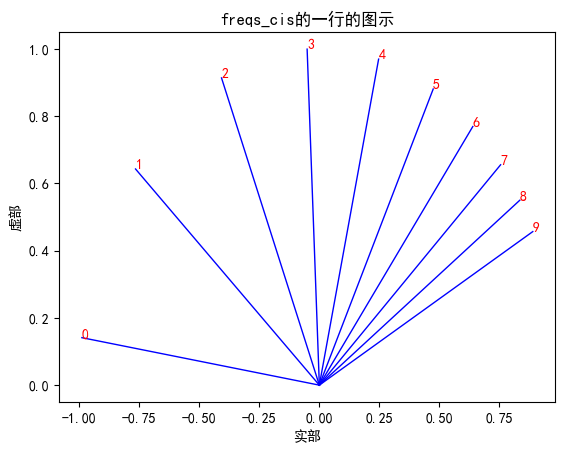

In [70]:
plt.rcParams["font.sans-serif"]=['simhei']
freqs_for_each_token = torch.outer(torch.arange(10), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# 查看freqs_cis的第三行
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:10]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('实部')
plt.ylabel('虚部')
plt.title('freqs_cis的一行的图示')
plt.show()


In [71]:
final_embedding = token_embeddings_unnormalized
for layer in tqdm(range(n_layers)):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:59<00:00,  1.87s/it]


In [72]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
next_token = torch.argmax(logits, dim=-1)
tokenizer.decode([next_token.item()])

' data'

# 备注：部分代码草稿

In [ ]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_layer0_head0 = k_layer0[0]
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)

In [ ]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5

In [ ]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
qk_per_token_after_masking = qk_per_token + mask
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

In [ ]:
v_layer0_head0 = v_layer0[0]
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

In [ ]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

# len(qkv_attention_store)
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)

w_layer0 = model["layers.0.attention.wo.weight"]
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
layer_0_embedding = embedding_after_edit+output_after_feedforward

In [ ]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [ ]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
next_token = torch.argmax(logits, dim=-1)
tokenizer.decode([next_token.item()])